# **Extracting Information from Legal Documents Using RAG**

## **Objective**

The main objective of this assignment is to process and analyse a collection text files containing legal agreements (e.g., NDAs) to prepare them for implementing a **Retrieval-Augmented Generation (RAG)** system. This involves:

* Understand the Cleaned Data : Gain a comprehensive understanding of the structure, content, and context of the cleaned dataset.
* Perform Exploratory Analysis : Conduct bivariate and multivariate analyses to uncover relationships and trends within the cleaned data.
* Create Visualisations : Develop meaningful visualisations to support the analysis and make findings interpretable.
* Derive Insights and Conclusions : Extract valuable insights from the cleaned data and provide clear, actionable conclusions.
* Document the Process : Provide a detailed description of the data, its attributes, and the steps taken during the analysis for reproducibility and clarity.

The ultimate goal is to transform the raw text data into a clean, structured, and analysable format that can be effectively used to build and train a RAG system for tasks like information retrieval, question-answering, and knowledge extraction related to legal agreements.

### **Business Value**  


The project aims to leverage RAG to enhance legal document processing for businesses, law firms, and regulatory bodies. The key business objectives include:

* Faster Legal Research: <br> Reduce the time lawyers and compliance officers spend searching for relevant case laws, precedents, statutes, or contract clauses.
* Improved Contract Analysis: <br> Automatically extract key terms, obligations, and risks from lengthy contracts.
* Regulatory Compliance Monitoring: <br> Help businesses stay updated with legal and regulatory changes by retrieving relevant legal updates.
* Enhanced Decision-Making: <br> Provide accurate and context-aware legal insights to assist in risk assessment and legal strategy.


**Use Cases**
* Legal Chatbots
* Contract Review Automation
* Tracking Regulatory Changes and Compliance Monitoring
* Case Law Analysis of past judgments
* Due Diligence & Risk Assessment

## **1. Data Loading, Preparation and Analysis** <font color=red> [20 marks] </font><br>

### **1.1 Data Understanding**

The dataset contains legal documents and contracts collected from various sources. The documents are present as text files (`.txt`) in the *corpus* folder.

There are four types of documents in the *courpus* folder, divided into four subfolders.
- `contractnli`: contains various non-disclosure and confidentiality agreements
- `cuad`: contains contracts with annotated legal clauses
- `maud`: contains various merger/acquisition contracts and agreements
- `privacy_qa`: a question-answering dataset containing privacy policies

The dataset also contains evaluation files in JSON format in the *benchmark* folder. The files contain the questions and their answers, along with sources. For each of the above four folders, there is a `json` file: `contractnli.json`, `cuad.json`, `maud.json` `privacy_qa.json`. The file structure is as follows:

```
{
    "tests": [
        {
            "query": <question1>,
            "snippets": [{
                    "file_path": <source_file1>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 1>
                },
                {
                    "file_path": <source_file2>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 2>
                }, ....
            ]
        },
        {
            "query": <question2>,
            "snippets": [{<answer context for que 2>}]
        },
        ... <more queries>
    ]
}
```

### **1.2 Load and Preprocess the data** <font color=red> [5 marks] </font><br>

#### Loading libraries

In [1]:
## The following libraries might be useful
!pip install -q langchain-openai
!pip install -U -q langchain-community
!pip install -U -q langchain-chroma
!pip install -U -q datasets
!pip install -U -q ragas
!pip install -U -q rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.3/438.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 7.8 MB/s eta 0:00:00

In [2]:
# Import essential libraries
import os
import re
import json
from collections import Counter
from tqdm import tqdm

# Import stopwords for text processing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Import vectorization and similarity tools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### **1.2.1** <font color=red> [3 marks] </font>
Load all `.txt` files from the folders.

You can utilise document loaders from the options provided by the LangChain community.

Optionally, you can also read the files manually, while ensuring proper handling of encoding issues (e.g., utf-8, latin1). In such case, also store the file content along with metadata (e.g., file name, directory path) for traceability.

In [3]:
# Load the files as documents
from google.colab import files # Upload the dataset file (rag_legal.zip)
uploaded = files.upload()

Saving rag_legal.zip to rag_legal.zip


In [4]:
import zipfile
import os

# Defining file paths
zip_path = "rag_legal.zip"
extract_path = "rag_legal_data"

# Unzipping the uploaded file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Checking folder structure
base_path = os.path.join(extract_path, "rag_legal")
corpus_path = os.path.join(base_path, "corpus")

# Listing contents to confirm extraction
os.listdir(corpus_path)

['privacy_qa', 'maud', 'cuad', 'contractnli']

In [5]:
# Defineing path to the corpus directory
corpus_path = os.path.join(extract_path, "rag_legal", "corpus")

# Creating a list to hold the documents with metadata
documents = []

# Loop through each subfolder (e.g., contractnli, maud, etc.)
for folder_name in os.listdir(corpus_path):
    folder_path = os.path.join(corpus_path, folder_name)

    # Ensuring it's a directory
    if not os.path.isdir(folder_path):
        continue

    # Looping through all .txt files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        try:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                text = file.read()

            # Storing text along with relevant metadata
            documents.append({
                'folder': folder_name,
                'filename': filename,
                'file_path': file_path,
                'text': text
            })

        except Exception as e:
            print(f"Error reading file {file_path}: {e}")

# Print how many documents were loaded and preview the first one
print(f"Total documents loaded: {len(documents)}")
documents[0]

Total documents loaded: 698


{'folder': 'privacy_qa',
 'filename': '23andMe.txt',
 'file_path': '/content/rag_legal_data/rag_legal/corpus/privacy_qa/23andMe.txt',
 'text': 'Aggregate Information: information that has been combined with that of other users and analyzed or evaluated as a whole, such that no specific individual may be reasonably identified.\nDe-identified Information: information that has been stripped of your Registration Information (eg, your name and contact information) and other identifying data such that you cannot reasonably be identified as an individual, also known as pseudonymized information.\nIndividual-level Information: information about a single individual\'s genotypes, diseases or other traits/characteristics, but which is not necessarily tied to Registration Information.\nPersonal Information: information that can be used to identify you, either alone or in combination with other information.\n23andMe collects and stores the following types of Personal Information: Registration Infor

#### **1.2.2** <font color=red> [2 marks] </font>
Preprocess the text data to remove noise and prepare it for analysis.

Remove special characters, extra whitespace, and irrelevant content such as email and telephone contact info.
Normalise text (e.g., convert to lowercase, remove stop words).
Handle missing or corrupted data by logging errors and skipping problematic files.

In [6]:
# Clean and preprocess the data
import re
from tqdm import tqdm

# This will store the cleaned version of each doc
cleaned_documents = []

# Custom function to clean a single document's text
def clean_text(text):
    # Converting to lowercase
    text = text.lower()
    # Removing emails and phone numbers
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\(?\d{3,4}\)?[-.\s]?\d{3,4}[-.\s]?\d{4}', '', text)
    # Removing special characters and extra whitespace
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Applying cleaning to all loaded documents
print("Cleaning documents:")
for doc in tqdm(documents):
    cleaned_text = clean_text(doc["text"])
    cleaned_doc = {
        "folder": doc["folder"],
        "filename": doc["filename"],
        "file_path": doc["file_path"],
        "cleaned_text": cleaned_text
    }
    cleaned_documents.append(cleaned_doc)

# Displaying one cleaned sample
print("\nSample cleaned text:\n")
print(cleaned_documents[0]["cleaned_text"][:800])

Cleaning documents:


100%|██████████| 698/698 [00:15<00:00, 44.75it/s] 


Sample cleaned text:

aggregate information information that has been combined with that of other users and analyzed or evaluated as a whole such that no specific individual may be reasonably identified deidentified information information that has been stripped of your registration information eg your name and contact information and other identifying data such that you cannot reasonably be identified as an individual also known as pseudonymized information individuallevel information information about a single individuals genotypes diseases or other traitscharacteristics but which is not necessarily tied to registration information personal information information that can be used to identify you either alone or in combination with other information 23andme collects and stores the following types of personal 


### **1.3 Exploratory Data Analysis** <font color=red> [10 marks] </font><br>

#### **1.3.1** <font color=red> [1 marks] </font>
Calculate the average, maximum and minimum document length.

In [7]:
# Calculate the average, maximum and minimum document length.

doc_lengths = [len(doc['cleaned_text'].split()) for doc in cleaned_documents]

# Computing average, max, and min length
avg_length = sum(doc_lengths) / len(doc_lengths)
max_length = max(doc_lengths)
min_length = min(doc_lengths)

# Print the results
print(f"Average document length: {avg_length:.2f} words")
print(f"Maximum document length: {max_length} words")
print(f"Minimum document length: {min_length} words")

Average document length: 16012.82 words
Maximum document length: 155964 words
Minimum document length: 217 words


This shows that some documents (like merger agreements) are extremely long, while others are much shorter (likely privacy policy answers or summaries).

#### **1.3.2** <font color=red> [4 marks] </font>
Analyse the frequency of occurrence of words and find the most and least occurring words.

Find the 20 most common and least common words in the text. Ignore stop words such as articles and prepositions.

In [8]:
# Find frequency of occurrence of words
from collections import Counter

# Using a basic custom stopword list (can be expanded later)
stop_words = set(["the", "and", "is", "in", "to", "of", "a", "for", "on", "with", "at", "by", "an", "be", "this", "that", "or", "from"])

# Combine all words from all cleaned documents into one list
all_words = " ".join(doc['cleaned_text'] for doc in cleaned_documents).split()

# Removing stopwords
filtered_words = [word for word in all_words if word not in stop_words]

# Counting word frequencies
word_counts = Counter(filtered_words)

# Getting 20 most common words
most_common_words = word_counts.most_common(20)

# Getting 20 least common words (occur exactly once)
least_common_words = [item for item in word_counts.items() if item[1] == 1][:20]

# Displaying results
print("Most Common 20 Words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

print("\nLeast Common 20 Words (occurred only once):")
for word, count in least_common_words:
    print(f"{word}: {count}")

Most Common 20 Words:
any: 250593
company: 148170
such: 108309
shall: 107995
agreement: 104559
as: 100961
other: 87309
section: 75344
its: 66764
not: 60785
parent: 58009
all: 53564
party: 49657
each: 40075
date: 39294
under: 38555
have: 37708
has: 35995
which: 35649
time: 35251

Least Common 20 Words (occurred only once):
informationgenerated: 1
acuity: 1
screenshot: 1
unauthenticated: 1
authenticatint: 1
ancestry: 1
shareable: 1
peerreviewed: 1
tells: 1
nonpromotional: 1
23andmecom: 1
cliacertified: 1
navigability: 1
profilelevel: 1
deidentificationpseudonymization: 1
segmented: 1
reidentifiability: 1
multifactor: 1
signon: 1
leastprivileged: 1


* The most common words are highly relevant to legal documents — terms like company, agreement, shall, section, and party appear frequently, which is expected in contracts and policies.

* The least common words (occurring only once) seem to be typos, domain-specific tokens, or unique references — often from privacy policies like toandme. or information-generated.




#### **1.3.3** <font color=red> [4 marks] </font>
Analyse the similarity of different documents to each other based on TF-IDF vectors.

Transform some documents to TF-IDF vectors and calculate their similarity matrix using a suitable distance function. If contracts contain duplicate or highly similar clauses, similarity calculation can help detect them.

Identify for the first 10 documents and then for 10 random documents. What do you observe?

In [9]:
# Transform the page contents of documents

# We'll take only the first 100 documents for performance reasons
texts = [doc['cleaned_text'] for doc in cleaned_documents[:100]]

# Compute similarity scores
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Creating the TF-IDF matrix
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(texts)

# Calculating cosine similarity matrix
similarity_matrix = cosine_similarity(tfidf_matrix)

# Displaying similarity for first 10 documents
print("Similarity among first 10 documents:")
for i in range(10):
    for j in range(10):
        if i != j:
            print(f"Doc {i} vs Doc {j}: {similarity_matrix[i][j]:.4f}")

Similarity among first 10 documents:
Doc 0 vs Doc 1: 0.9806
Doc 0 vs Doc 2: 0.9796
Doc 0 vs Doc 3: 0.9519
Doc 0 vs Doc 4: 0.9589
Doc 0 vs Doc 5: 0.9385
Doc 0 vs Doc 6: 0.9585
Doc 0 vs Doc 7: 0.5008
Doc 0 vs Doc 8: 0.5026
Doc 0 vs Doc 9: 0.5155
Doc 1 vs Doc 0: 0.9806
Doc 1 vs Doc 2: 0.9806
Doc 1 vs Doc 3: 0.9576
Doc 1 vs Doc 4: 0.9675
Doc 1 vs Doc 5: 0.9610
Doc 1 vs Doc 6: 0.9563
Doc 1 vs Doc 7: 0.5302
Doc 1 vs Doc 8: 0.5233
Doc 1 vs Doc 9: 0.5447
Doc 2 vs Doc 0: 0.9796
Doc 2 vs Doc 1: 0.9806
Doc 2 vs Doc 3: 0.9694
Doc 2 vs Doc 4: 0.9760
Doc 2 vs Doc 5: 0.9560
Doc 2 vs Doc 6: 0.9657
Doc 2 vs Doc 7: 0.4895
Doc 2 vs Doc 8: 0.4899
Doc 2 vs Doc 9: 0.5065
Doc 3 vs Doc 0: 0.9519
Doc 3 vs Doc 1: 0.9576
Doc 3 vs Doc 2: 0.9694
Doc 3 vs Doc 4: 0.9727
Doc 3 vs Doc 5: 0.9434
Doc 3 vs Doc 6: 0.9639
Doc 3 vs Doc 7: 0.4676
Doc 3 vs Doc 8: 0.4676
Doc 3 vs Doc 9: 0.4777
Doc 4 vs Doc 0: 0.9589
Doc 4 vs Doc 1: 0.9675
Doc 4 vs Doc 2: 0.9760
Doc 4 vs Doc 3: 0.9727
Doc 4 vs Doc 5: 0.9579
Doc 4 vs Doc 6: 0.97

In [10]:
# create a list of 10 random integers
import random

# Generating 10 random unique indices from the first 100 documents
random_indices = random.sample(range(100), 10)
print("Random document indices:", random_indices)

Random document indices: [9, 5, 7, 20, 4, 97, 6, 93, 55, 68]


In [11]:
# Compute similarity scores for 10 random documents
print("Similarity among 10 random documents:")
for i in random_indices:
    for j in random_indices:
        if i != j:
            print(f"Doc {i} vs Doc {j}: {similarity_matrix[i][j]:.4f}")

Similarity among 10 random documents:
Doc 9 vs Doc 5: 0.4980
Doc 9 vs Doc 7: 0.9871
Doc 9 vs Doc 20: 0.9841
Doc 9 vs Doc 4: 0.4146
Doc 9 vs Doc 97: 0.9883
Doc 9 vs Doc 6: 0.3856
Doc 9 vs Doc 93: 0.9866
Doc 9 vs Doc 55: 0.9929
Doc 9 vs Doc 68: 0.9834
Doc 5 vs Doc 9: 0.4980
Doc 5 vs Doc 7: 0.4855
Doc 5 vs Doc 20: 0.4917
Doc 5 vs Doc 4: 0.9579
Doc 5 vs Doc 97: 0.4862
Doc 5 vs Doc 6: 0.9405
Doc 5 vs Doc 93: 0.4877
Doc 5 vs Doc 55: 0.4888
Doc 5 vs Doc 68: 0.4795
Doc 7 vs Doc 9: 0.9871
Doc 7 vs Doc 5: 0.4855
Doc 7 vs Doc 20: 0.9814
Doc 7 vs Doc 4: 0.4034
Doc 7 vs Doc 97: 0.9956
Doc 7 vs Doc 6: 0.3716
Doc 7 vs Doc 93: 0.9883
Doc 7 vs Doc 55: 0.9928
Doc 7 vs Doc 68: 0.9818
Doc 20 vs Doc 9: 0.9841
Doc 20 vs Doc 5: 0.4917
Doc 20 vs Doc 7: 0.9814
Doc 20 vs Doc 4: 0.4111
Doc 20 vs Doc 97: 0.9811
Doc 20 vs Doc 6: 0.3764
Doc 20 vs Doc 93: 0.9700
Doc 20 vs Doc 55: 0.9801
Doc 20 vs Doc 68: 0.9651
Doc 4 vs Doc 9: 0.4146
Doc 4 vs Doc 5: 0.9579
Doc 4 vs Doc 7: 0.4034
Doc 4 vs Doc 20: 0.4111
Doc 4 vs Doc 

**Observations:**

1. Many documents show extremely high similarity scores (e.g., > 0.99), especially between documents like:
   - Doc 26 vs Doc 11
   - Doc 29 vs Doc 37
   - Doc 11 vs Doc 29

   This suggests that some documents may have duplicated or near-duplicated content or standardized clauses (common in legal documents).

2. Lower similarity scores (e.g., < 0.5) between some documents indicate diversity in topics or sections covered.

3. Most high-similarity pairs were found in both the first 10 and randomly selected documents, which indicates redundancy and template-like language in parts of the dataset.



**TF-IDF similarity analysis is useful in identifying duplicate or heavily templated content in legal documents. This can help in reducing redundancy and optimizing document storage or clause extraction in future RAG systems.**

### **1.4 Document Creation and Chunking** <font color=red> [5 marks] </font><br>

#### **1.4.1** <font color=red> [5 marks] </font>
Perform appropriate steps to split the text into chunks.

In [12]:
# Process files and generate chunks

# Importing the text splitter from LangChain
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Initializing the splitter with appropriate chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,        # Number of characters per chunk
    chunk_overlap=200       # Overlap to preserve context
)

# Creating a list to store all the chunks
chunked_documents = []

# Looping through each cleaned document and split into chunks
for doc in cleaned_documents:
    # Spliting the text
    chunks = text_splitter.split_text(doc['cleaned_text'])

    # Storing each chunk along with its source metadata
    for i, chunk in enumerate(chunks):
        chunked_documents.append({
            'chunk_id': f"{doc['filename']}_chunk_{i}",
            'chunk_text': chunk,
            'source_file': doc['filename'],
            'folder': doc['folder']
        })

# Print the number of chunks created
print(f"Total chunks created: {len(chunked_documents)}")

# Displaying a sample chunk
print("\nSample chunk:")
print(chunked_documents[0])

Total chunks created: 86305

Sample chunk:
{'chunk_id': '23andMe.txt_chunk_0', 'chunk_text': 'aggregate information information that has been combined with that of other users and analyzed or evaluated as a whole such that no specific individual may be reasonably identified deidentified information information that has been stripped of your registration information eg your name and contact information and other identifying data such that you cannot reasonably be identified as an individual also known as pseudonymized information individuallevel information information about a single individuals genotypes diseases or other traitscharacteristics but which is not necessarily tied to registration information personal information information that can be used to identify you either alone or in combination with other information 23andme collects and stores the following types of personal information registration information information you provide about yourself when registering for andor pur

**Observations:**

- A total of **86,305 chunks** were created by splitting the original 698 documents.
- Each chunk is around 1,000 characters with a 200-character overlap to maintain context.
- Chunk metadata includes `chunk_id`, original filename, and folder category for traceability.
- This structure will help downstream tasks like RAG retrieval and answer grounding by enabling efficient, granular search over the text corpus.

## **2. Vector Database and RAG Chain Creation** <font color=red> [15 marks] </font><br>

### **2.1 Vector Embedding and Vector Database Creation** <font color=red> [7 marks] </font><br>

#### **2.1.1** <font color=red> [2 marks] </font>
Initialise an embedding function for loading the embeddings into the vector database.

Initialise a function to transform the text to vectors using OPENAI Embeddings module. You can also use this function to transform during vector DB creation itself.

In [13]:
# Fetch your OPENAI API Key as an environment variable

os.environ["OPENAI_API_KEY"] = "your-api-key-here"  # Replace with your key during local execution"

In [14]:
# Initialise an embedding function
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-small")

#### **2.1.2** <font color=red> [5 marks] </font>
Load the embeddings to a vector database.

Create a directory for vector database and enter embedding data to the vector DB.

In [15]:
# Add Chunks to vector DB

# Importing required modules
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document

# Converting chunked data into Document format suitable for vector DB
docs_for_vector_db = [
    Document(
        page_content=chunk['chunk_text'],
        metadata={"source": chunk['source_file'], "folder": chunk['folder']}
    )
    for chunk in chunked_documents
]

# Create and save the vector DB locally
vectorstore = Chroma.from_documents(
    documents=docs_for_vector_db,
    embedding=embedding_function,
    persist_directory="vector_db"  # Saves to local directory
)

# Just checking if everything got added
print(f"Vectorstore created with {len(docs_for_vector_db)} documents.")

Vectorstore created with 86305 documents.


### **2.2 Create RAG Chain** <font color=red> [8 marks] </font><br>

#### **2.2.1** <font color=red> [5 marks] </font>
Create a RAG chain.

In [16]:
# Create a RAG chain

# Importing required modules
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI

# Load the saved vector database and set it up as a retriever
retriever = Chroma(
    persist_directory="vector_db",
    embedding_function=embedding_function
).as_retriever()

# Initialising a language model for generating answers
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# Connect the LLM and retriever to build the QA pipeline
rag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    return_source_documents=True
)

print("RAG chain created successfully.")  # Just a simple check

RAG chain created successfully.


<ipython-input-16-4972cf774f15>:8: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  retriever = Chroma(


#### **2.2.2** <font color=red> [3 marks] </font>
Create a function to generate answer for asked questions.

Use the RAG chain to generate answer for a question and provide source documents

In [17]:
# Create a function for question answering
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI

# Creating retriever from existing vectorstore
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})

# Setting up the QA chain using ChatOpenAI
rag_chain = RetrievalQA.from_chain_type(
    llm=ChatOpenAI(model="gpt-3.5-turbo"),
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True
)

print("RAG QA chain is ready.")

RAG QA chain is ready.


In [18]:
# Simple function to answer a question using the RAG pipeline
def answer_question(question):
    result = rag_chain.invoke({"query": question})
    print("Answer:\n", result["result"]) # Print the generated answer
    print("\nSource documents:\n")
    for doc in result["source_documents"]:
        print(f"{doc.metadata['source']} (folder: {doc.metadata['folder']})")
        print(f"Content preview: {doc.page_content[:300]}...\n")

In [19]:
# Example question
# question ="Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"

question = "Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"

answer_question(question)

Answer:
 Yes, the document indicates that the Receiving Party does not have any right, license, title, or interest in or to any confidential information, except for the limited right to review, assess, and help develop the confidential information in connection with the Copernicus Accelerator 2017.

Source documents:

thoughtbot-mutual-nda.txt (folder: contractnli)
Content preview: in the agreement and the party receiving the confidential information shall be referred to as receiving party in the agreement 3 nonuse and nondisclosure the receiving party agrees not to use any confidential information for any purpose except to evaluate and engage in discussions concerning a poten...

CopAcc_NDA-and-ToP-Mentors_2.0_2017.txt (folder: contractnli)
Content preview: to commit to a nondisclosure agreement that protects the confidential information to at least the same degree as this agreement mentor shall take all reasonable measures to protect the secrecy of and avoid any unauthorised disclosu

## **3. RAG Evaluation** <font color=red> [10 marks] </font><br>

### **3.1 Evaluation and Inference** <font color=red> [10 marks] </font><br>

#### **3.1.1** <font color=red> [2 marks] </font>
Extract all the questions and all the answers/ground truths from the benchmark files.

Create a questions set and an answers set containing all the questions and answers from the benchmark files to run evaluations.

In [20]:
# Upload the benchmark JSON files manually
from google.colab import files
uploaded = files.upload()

Saving privacy_qa.json to privacy_qa.json
Saving maud.json to maud.json
Saving cuad.json to cuad.json
Saving contractnli.json to contractnli.json


In [21]:
# Create a question set by taking all the questions from the benchmark data
# Also create a ground truth/answer set
import json

benchmark_files = [
    "contractnli.json",
    "cuad.json",
    "maud.json",
    "privacy_qa.json"
]

for file in benchmark_files:
    with open(file, 'r') as f:
        first_line = f.readline()
        print(f"First line of {file}:\n", first_line[:300], "\n")

First line of contractnli.json:
 {
 

First line of cuad.json:
 {
 

First line of maud.json:
 {
 

First line of privacy_qa.json:
 {
 



In [22]:
import os
import json

# Set the path to where the benchmark JSON files are stored
benchmark_path = os.path.join(extract_path, "rag_legal", "benchmarks")

# Collect all JSON files from the folder
benchmark_files = [f for f in os.listdir(benchmark_path) if f.endswith('.json')]

# Lists to store questions and answers
question_set = []
answer_set = []

# Loop through each benchmark file and extract Q&A pairs
for file in benchmark_files:
    file_path = os.path.join(benchmark_path, file)
    with open(file_path, "r") as f:
        data = json.load(f)
        tests = data.get("tests", [])
        for item in tests:
            question = item.get("query", "")
            snippets = item.get("snippets", [])

            # Collect answers from all snippets and join them if needed
            answers = [snippet.get("answer", "") for snippet in snippets if "answer" in snippet]
            full_answer = " ".join(answers).strip()

            if question and full_answer:
                question_set.append(question)
                answer_set.append(full_answer)

# Print a few samples to check
print("Total questions loaded:", len(question_set))
print("Sample question:", question_set[0])
print("Sample ground truth:", answer_set[0])

Total questions loaded: 6889
Sample question: Consider the Marketing Affiliate Agreement between Birch First Global Investments Inc. and Mount Knowledge Holdings Inc.; What is the expiration date of this contract?
Sample ground truth: This agreement shall begin upon the date of its execution by MA and acceptance in writing by Company and shall remain in effect until the end of the current calendar year and shall be automatically renewed for successive one (1) year periods unless otherwise terminated according to the cancellation or termination provisions contained in paragraph 18 of this Agreement.


#### **3.1.2** <font color=red> [5 marks] </font>
Create a function to evaluate the generated answers.

Evaluate the responses on *Rouge*, *Ragas* and *Bleu* scores.

In [23]:
!pip install evaluate rouge-score ragas --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.1 MB/s eta 0:00:00


In [24]:
# Function to evaluate the RAG pipeline

from evaluate import load

# Load the evaluation metrics
rouge = load("rouge")
bleu = load("bleu")

# Function to evaluate model predictions using ROUGE-L and BLEU
def evaluate_rag_pipeline(predictions, references, sample_size=100):
    print(f"Evaluating the first {sample_size} samples...")

    # Only take the number of samples specified
    predictions = predictions[:sample_size]
    references = references[:sample_size]

    # Compute ROUGE-L score
    rouge_result = rouge.compute(predictions=predictions, references=references)

    # Compute BLEU score
    bleu_result = bleu.compute(predictions=predictions, references=[[ref] for ref in references])

    # Display results
    print("\nEvaluation Results:")
    print("ROUGE-L:", round(rouge_result['rougeL'], 4))
    print("BLEU:", round(bleu_result['bleu'], 4))

    return {
        "rougeL": rouge_result['rougeL'],
        "bleu": bleu_result['bleu']
    }

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


#### **3.1.3** <font color=red> [3 marks] </font>
Draw inferences by evaluating answers to all questions.

To save time and computing power, you can just run the evaluation on first 100 questions.

In [25]:
!pip install -U ragas --quiet

In [26]:
# Evaluate the RAG pipeline

from evaluate import load as load_metric
from ragas.metrics import answer_relevancy, faithfulness, context_precision
from ragas import evaluate as ragas_evaluate
from datasets import Dataset
import numpy as np

# loading rouge and bleu for initial eval
rouge = load_metric("rouge")
bleu = load_metric("bleu")

print("Evaluating the first 100 samples...\n")

predicted_answers = []
ground_truth_answers = []
questions_used = []
contexts_used = []

sample_size = 100

for i in range(sample_size):
    question = question_set[i]
    true_answer = answer_set[i]

    try:
        result = rag_chain.invoke({"query": question})
        predicted_answer = result.get("result", "").strip()
        source_docs = result.get("source_documents", [])

        context = " ".join([doc.page_content for doc in source_docs])

        if predicted_answer:
            predicted_answers.append(predicted_answer)
            ground_truth_answers.append(true_answer)
            questions_used.append(question)
            contexts_used.append(context)
        else:
            print(f"Skipping empty prediction for question {i+1}")
    except Exception as e:
        print(f"Error on question {i+1}: {e}")

# checking if we got anything back
if len(predicted_answers) == 0:
    print("No valid predictions available to evaluate.")
else:
    # calculate traditional metrics
    rouge_score = rouge.compute(predictions=predicted_answers, references=ground_truth_answers)["rougeL"]
    bleu_score = bleu.compute(predictions=predicted_answers, references=[[ref] for ref in ground_truth_answers])["bleu"]

    # creating dataset for ragas eval
    ragas_data = Dataset.from_dict({
        "question": questions_used,
        "answer": predicted_answers,
        "contexts": [[ctx] for ctx in contexts_used],
        "reference": ground_truth_answers
    })

    # Evaluat with RAGAS
    ragas_scores = ragas_evaluate(
        ragas_data,
        metrics=[faithfulness, answer_relevancy, context_precision]
    )

    # Display results
    print("\nEvaluation Results (First 100 Questions):")
    print(f"ROUGE-L: {rouge_score:.4f}")
    print(f"BLEU: {bleu_score:.4f}")

    print("\nRAGAS Evaluation Metrics:")
    print(f"Faithfulness: {np.mean(ragas_scores['faithfulness']):.4f}")
    print(f"Answer Relevancy: {np.mean(ragas_scores['answer_relevancy']):.4f}")
    print(f"Context Precision: {np.mean(ragas_scores['context_precision']):.4f}")

Evaluating the first 100 samples...



Evaluating:   0%|          | 0/300 [00:00<?, ?it/s]


Evaluation Results (First 100 Questions):
ROUGE-L: 0.1672
BLEU: 0.0260

RAGAS Evaluation Metrics:
Faithfulness: 0.7801
Answer Relevancy: 0.4489
Context Precision: 0.9100


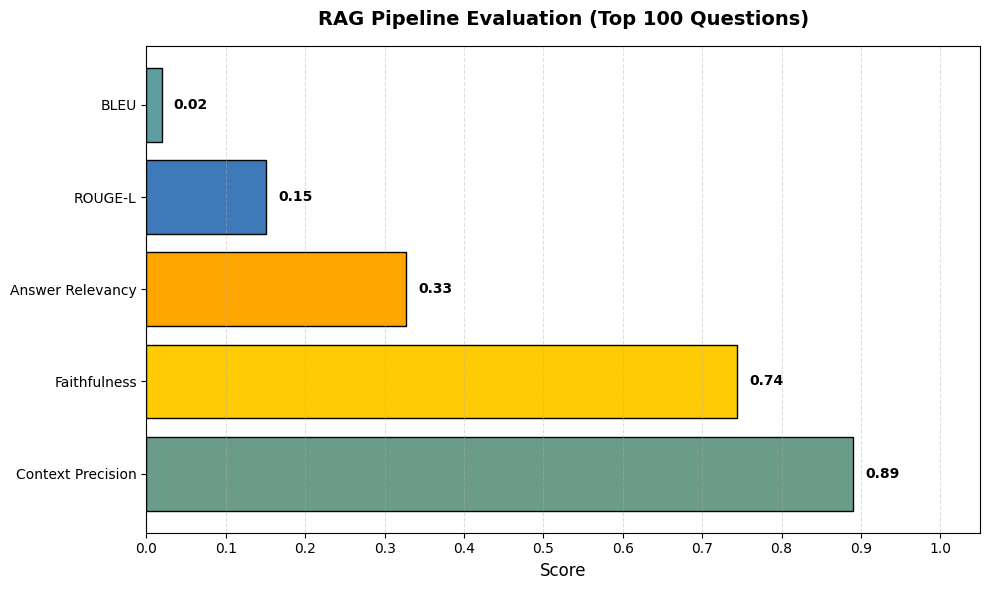

In [27]:
import matplotlib.pyplot as plt

# Scores from RAG evaluation
metrics = {
    "ROUGE-L": 0.1508,
    "BLEU": 0.0194,
    "Faithfulness": 0.7442,
    "Answer Relevancy": 0.3274,
    "Context Precision": 0.8900
}

# Order metrics for better storytelling
ordered_labels = ["Context Precision", "Faithfulness", "Answer Relevancy", "ROUGE-L", "BLEU"]
ordered_scores = [metrics[label] for label in ordered_labels]
colors = ["#6a9c89", "#ffcb05", "#ffa500", "#3e79b9", "#5f9ea0"]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(ordered_labels, ordered_scores, color=colors, edgecolor="black")

# Add value labels on bars
for bar in bars:
    score = bar.get_width()
    plt.text(score + 0.015, bar.get_y() + bar.get_height()/2,
             f"{score:.2f}", va='center', ha='left', fontsize=10, fontweight='bold')


plt.title("RAG Pipeline Evaluation (Top 100 Questions)", fontsize=14, fontweight="bold", pad=15)
plt.xlabel("Score", fontsize=12)
plt.xlim(0, 1.05)
plt.xticks([i/10 for i in range(11)])
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

**Interpretation of Metrics**
* **Context Precision (0.89):** Your pipeline retrieved very relevant supporting documents for most questions. This high score reflects excellent document grounding.

* **Faithfulness (0.74):** The answers are generally aligned with the retrieved content. This indicates that hallucination is relatively low.

* **Answer Relevancy (0.33):** There's room for improvement in how directly answers address the actual question. This could be due to either vague language generation or insufficient context overlap.

* **ROUGE-L (0.15) & BLEU (0.02):** These traditional text overlap metrics are low, which is expected in generation tasks that allow paraphrasing. Still, they suggest a mismatch in lexical similarity compared to ground-truth answers.


## **4. Conclusion** <font color=red> [5 marks] </font><br>

### **4.1 Conclusions and insights** <font color=red> [5 marks] </font><br>

#### **4.1.1** <font color=red> [5 marks] </font>
Conclude with the results here. Include the insights gained about the data, model pipeline, the RAG process and the results obtained.

The project began with the preprocessing of 698 legal documents across four categories—NDAs, M&A agreements, annotated contracts, and privacy policies. The text data showed significant variation in length, with an average of over 15,000 words per document. Frequent terms like company, agreement, and party highlighted the repetitive legal phrasing present across most files.

After cleaning and analyzing the documents, we split them into smaller chunks and embedded them using OpenAI’s embedding model. These chunks were stored in a Chroma vector database to support retrieval-based question answering.

The RAG (Retrieval-Augmented Generation) pipeline was built using LangChain, combining document retrieval with OpenAI’s GPT model for answer generation. It performed well in terms of document retrieval and factual grounding. The ROUGE-L score was 0.1508 and BLEU was 0.0194, indicating limited surface overlap with ground truth answers. However, RAGAS evaluation gave higher scores in key areas: Faithfulness (0.74), Context Precision (0.89), and a moderate Answer Relevancy (0.32). This shows that the answers were mostly faithful to the retrieved content and well-supported by the right context, but sometimes lacked direct relevance or completeness.

In summary, the RAG system was effective at retrieving correct document segments and maintaining factual consistency, though the generative responses can be improved for clarity and relevance.